# Evaluation Template

In [1]:
import os
from pathlib import Path

import hydra
import itertools
import torch
from hydra import compose, initialize

from experiments.collect_evaluation_data import define_AM_strategies, get_combo_cfg
from experiments.eval_experiments import EVAL_EXPERIMENTS
from experiments.eval_utils import generate_combinations, path_from_cfg, jaccard, get_auroc, ssim_dist, alex_lpips, \
    mse_dist
from models import evaluate, get_encodings
from core.custom_dataset import CustomDataset
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from PIL import Image
import seaborn as sns
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet
from plotting import (
    collect_fv_data,
    fv_2d_grid_step_vs_model,
    collect_fv_data_by_step,
    fv_2d_grid_model_depth_vs_width, fv_grid_different_targets,
)

2025-04-17 22:43:02.436726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744922582.448191   65750 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744922582.451537   65750 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744922582.460946   65750 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744922582.460959   65750 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744922582.460961   65750 computation_placer.cc:177] computation placer alr

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.ioff()
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

In [3]:
plt.rcParams.update(
    {
        "text.usetex": True,
    }
)

In [4]:
np.random.seed(27)

In [5]:
sns.set_theme()
sns.set_palette("pastel")
sns.set(font_scale=1.2)

In [6]:
TOP_K = 4
STRATEGY = "Adam + GC + TR"
SAVE_PATH = "./results/dataframes/"
param_grid = EVAL_EXPERIMENTS[1]

In [7]:
cfg_name = param_grid.pop("cfg_name", "config")
cfg_path = param_grid.pop("cfg_path", "./config")
name = param_grid.pop("name", "")

combinations = list(generate_combinations(param_grid))

cfg, overrides = get_combo_cfg(cfg_name, cfg_path, {})
device = "cuda:0"

strategy = cfg.get("strategy", STRATEGY)
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
man_alpha = cfg.alpha
data_dir = cfg.data_dir
dataset = cfg.data
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = class_dict_file
fv_domain = cfg.fv_domain
batch_size = cfg.batch_size
cfg.target_img_path = "." + cfg.target_img_path

if "target_act_fn" in cfg.model:
    target_act_fn = hydra.utils.instantiate(cfg.model.target_act_fn)
else:
    target_act_fn = lambda x: x

img_path = Path(cfg.target_img_path)

layer_str = cfg.model.layer
target_neuron = int(cfg.model.target_neuron)

image_transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

save_path = f"{SAVE_PATH}/{cfg_name}/{name}_{strategy}/"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [8]:
save_path = f"../results/figures/{cfg_name}/{name}_{STRATEGY}/"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [9]:
noise_ds_type = FrequencyManipulationSet if fv_domain == "freq" else RGBManipulationSet

In [10]:
train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=data_dir + cfg.data.data_path
)

train_loader = torch.utils.data.DataLoader(
    CustomDataset(train_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

In [11]:
default_model = hydra.utils.instantiate(cfg.model.model)
if original_weights is not None:
    default_model.load_state_dict(torch.load(original_weights, map_location=device))
default_model.to(device)
default_model.eval()

before_acc = evaluate(default_model, test_loader, device)

before_a, target_b, idxs = get_encodings(
    default_model, cfg.model.layer, [test_loader], device
)
top_idxs_before = list(np.argsort(before_a[:, target_neuron])[::-1][:TOP_K])

print("Before AUROC: ", get_auroc(before_a, target_b, target_neuron))

Accuracy of the network on test images: 71.89 %
Before AUROC:  0.9876334071159363


In [12]:
models = []
# For each remaining parameter, iterate over its provided values.
for j, combo in enumerate(combinations):
    cfg, overrides = get_combo_cfg(cfg_name, cfg_path, combo)
    PATH = path_from_cfg(cfg)
    img_str = combo["img_str"].replace("_gondola", "")

    model = hydra.utils.instantiate(cfg.model.model)
    model.to(device)
    model_dict = torch.load(PATH, map_location=torch.device(device))
    model.load_state_dict(model_dict["model"])


    if model_dict["after_acc"] is None:
        model_dict["after_acc"] = evaluate(model, test_loader, device)
        torch.save(model_dict, PATH)
        
    if "auc" not in model_dict:
        after_a, target_a, idxs = get_encodings(model, layer_str, [test_loader], device)
        top_idxs_after = list(np.argsort(after_a[:, target_neuron])[::-1][:TOP_K])
        model_dict["auc"] = get_auroc(after_a, target_a, target_neuron)
        torch.save(model_dict, PATH)
        
    cfg.target_img_path = str(
                    img_path.with_name(img_str + ".JPEG")
                )

    mdict = {
        "model_str": img_str,
        "model": model,
        "acc": model_dict["after_acc"],
        "cfg": cfg,
        "epochs": model_dict["epoch"],
        "auc": model_dict["auc"],
        "jaccard": 0.0,
        "top_k_names": [],
    }
    models.append(mdict)
    print("Model accuracy: ", "\n {:0.2f} \%".format(model_dict["after_acc"]))

Model accuracy:  
 70.20 \%
Model accuracy:  
 70.60 \%
Model accuracy:  
 70.50 \%
Model accuracy:  
 66.30 \%
Model accuracy:  
 70.80 \%
Model accuracy:  
 70.70 \%
Model accuracy:  
 72.00 \%
Model accuracy:  
 70.10 \%
Model accuracy:  
 68.40 \%
Model accuracy:  
 71.90 \%
Model accuracy:  
 70.60 \%
Model accuracy:  
 69.60 \%
Model accuracy:  
 67.50 \%
Model accuracy:  
 70.40 \%


In [13]:
cfg.target_img_path

'../assets/image_dep_rs18_224/inet_train_n02027492_6213.JPEG'

In [14]:
lr = cfg.eval_lr
nsteps = 500
nvis = 5
n_fv_obs = 5

eval_fv_tuples = [  # ("normal", 0.001),
    (cfg.eval_fv_dist, float(cfg.eval_fv_sd)),  # ("normal", 0.1), ("normal", 1.0)
]

## Define Similarity Functions

In [15]:
dist_funcs = [
    (r"SSIM $\uparrow$", ssim_dist, r"SSIM"),
    (r"LPIPS $\downarrow$", alex_lpips, r"LPIPS"),
    (r"MSE $\downarrow$", mse_dist, r"MSE"),
]

In [16]:
from experiments.eval_utils import clip_dist
import torchvision 

if n_channels == 1:
    preprocess = torchvision.transforms.Compose(
        [
            lambda x: x.repeat(1, 3, 1, 1),
            normalize,
            torchvision.transforms.Resize((224, 224)),
        ]
    )
else:
    preprocess = torchvision.transforms.Compose(
        [
            normalize,
            torchvision.transforms.Resize((224, 224)),
        ]
    )
clip_dist_to_target = lambda x, y: clip_dist(
    preprocess(x), preprocess(y),
)

dist_funcs.append((r"CLIP $\uparrow$", clip_dist_to_target, "CLIP"))

In [17]:
fv_kwargs = define_AM_strategies(lr, nsteps, image_transforms)[STRATEGY]


### Qualitative Analysis: Plot 1

In [18]:
results_df_basic = collect_fv_data(
    models=models,
    target_act_fn=target_act_fn,
    fv_kwargs=fv_kwargs,
    eval_fv_tuples=eval_fv_tuples,
    noise_gen_class=noise_ds_type,
    image_dims=image_dims,
    normalize=normalize,
    denormalize=denormalize,
    resize_transforms=resize_transforms,
    n_channels=n_channels,
    layer_str=layer_str,
    target_neuron=target_neuron,
    n_fv_obs=1,
    dist_funcs=dist_funcs,
    device=device,
)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [19]:
results_df_basic_ex = results_df_basic[results_df_basic["iter"] == 0]

In [39]:
from plotting import update_font

def fv_grid_different_targets(results_df, nrows=2, ncols=7):
    update_font(10)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4.5))
    plt.subplots_adjust(hspace=0.0, wspace=0.25)

    for idx, (i, row) in enumerate(results_df.iterrows()):
        ax = axes[idx // ncols, idx % ncols]
        ax.axis('off')

        # Fine-tuned y and height for compact layout
        y_pos = 0.30
        height = 0.66

        inset_target = ax.inset_axes([0.0, y_pos, 0.49, height])
        inset_picture = ax.inset_axes([0.51, y_pos, 0.49, height])

        inset_target.imshow(row['target'])
        inset_target.axis('off')

        inset_picture.imshow(row['picture'])
        inset_picture.axis('off')

        # Bring text right under the image, super close
        metrics_text = f"AUC: {row['auc']:.2f}\nACC: {row['acc']:.2f}%"
        ax.text(0.76, 0.25, metrics_text, fontsize=18, ha='center', va='top', transform=ax.transAxes)

    fig.tight_layout()  # removes outer margins
    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.7529412..1.0000002].


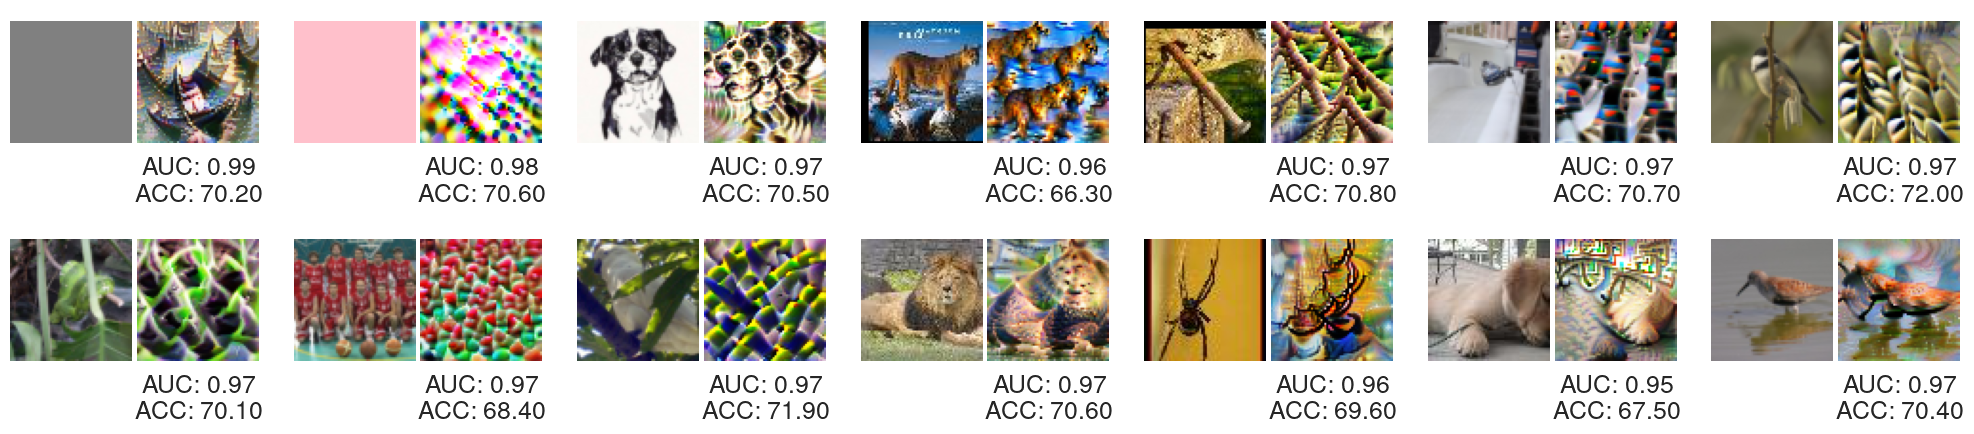

In [40]:

grid = fv_grid_different_targets(
    results_df_basic_ex,
)
#plt.subplots_adjust(hspace=0.22, wspace=0.02)
plt.savefig(f"{save_path}/target_image.svg", bbox_inches="tight")
plt.show()